# Load the Necessary Packages 

In [43]:
%load_ext autoreload
%autoreload 2

In [47]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Plot Recall, Precision, and F1 neatly
from utility.evaluation import load_type_dict, plot_evaluation, getMetrics

#Display matplotlib within jupyter notebook
plt.ion()

In [4]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train_hot.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test_hot.csv" ))

[6, 7, 8, 9]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


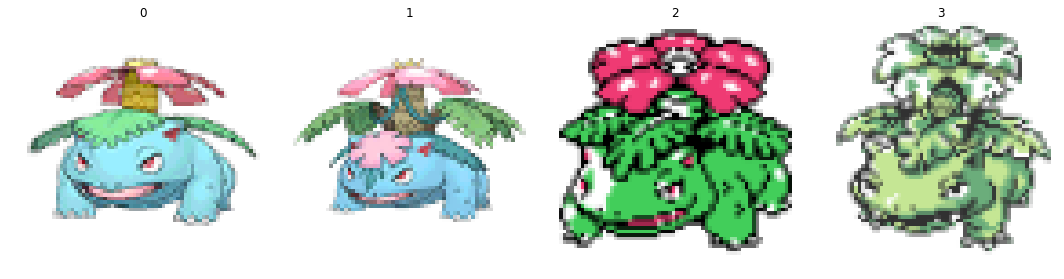

                                             pokemon dex_number normal  \
6  /home/tariq/PokemonTypeNN/data/xydex/venusaur.png          3      0   
7  /home/tariq/PokemonTypeNN/data/xydex/venusaurm...          3      0   
8    /home/tariq/PokemonTypeNN/data/gsc/venusaur.png          3      0   
9    /home/tariq/PokemonTypeNN/data/rby/venusaur.png          3      0   

  fighting flying poison ground rock bug ghost  ... blue3 green3 red4 blue4  \
6        0      0      1      0    0   0     0  ...   182    151  134   230   
7        0      0      1      0    0   0     0  ...   118    130   75   117   
8        0      0      1      0    0   0     0  ...   123     58   57   175   
9        0      0      1      0    0   0     0  ...   167    140   97   102   

  green4 proportion0 proportion1 proportion2 proportion3 proportion4  
6    170      0.0999      0.0629      0.0465      0.0447      0.0358  
7     84      0.0875      0.0539      0.0486      0.0424      0.0392  
8     77      0.2432

In [5]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(3,train_df)
print(temp_labels)

In [6]:
class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): optional transform to be applied to the samples"""
        
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        ###
        #Read the labels
        ###
        labels = self.df.iloc[index, 2:2+18].values
        labels = labels.astype("float").reshape(len(labels))
        
        ###
        #Read the 1-hot vector
        #
        #don't include proportion information; proportions are at the end
        less = (len(self.df.columns)-(2+18))//4
        one_hot = self.df.iloc[index, 2+18:-less].values
        one_hot = one_hot.astype("float").reshape(len(one_hot))
         
        if self.transform:
            one_hot = self.transform(one_hot)
            
        #Concat the images and labels as a "sample" dictionary
        sample = {"one_hot": one_hot, "labels":labels}
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]
        

# Load the Pokemon Datasets for the Neural Network

In [7]:
use_devset = False

theTransformations = None#transforms.Compose([transforms.ToTensor()])

###
#Load the Sets
###

#Trainset uses theTransformations; Test set only uses ToTensor
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train_hot.csv"),
                         transform= theTransformations)
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test_hot.csv" ),
                         transform = None)

if use_devset:
    devset   = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Dev_hot.csv"  ),
                             transform = None)

###
# Create DataLoaders
###
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True,  num_workers=4) #num_workers = 2
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=4)
if use_devset:
    devloader   = torch.utils.data.DataLoader(devset  , batch_size=16,
                                         shuffle=False, num_workers=4)

classes = list(train_df)[2:2+18]
x_len = ((len(train_df.columns)-(2+18))//4) * 3
print("Classes :: ",classes)
print("Input vector length :: ", x_len)

Classes ::  ['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']
Input vector length ::  15


In [8]:
for i, (minibatch, index) in enumerate(trainloader):
    print(minibatch)

{'one_hot': tensor([[100., 100., 100., 154., 154., 154., 102.,  97., 102.,  53.,  53.,  53.,
         144., 141., 144.],
        [179., 170., 153.,  88.,  86.,  82.,  33.,  33.,  41.,  83.,  74.,  82.,
          50.,  48.,  48.],
        [141.,  79.,  60., 254., 196.,  89., 216., 154.,  94., 210.,  85.,  57.,
          59.,  51.,  49.],
        [188., 131.,  25.,  40.,  22.,  10., 142.,  94.,  41., 176., 160., 134.,
         101.,  70.,  16.],
        [236., 208., 230., 184., 158., 174.,  71., 101., 128., 211., 180., 200.,
         120.,  97., 114.],
        [247., 231.,  69., 180., 170., 126., 187., 150., 166., 232., 221., 230.,
         179., 159.,  53.],
        [119., 175., 127., 194., 226., 146.,  80., 108.,  85.,  94.,  97.,  88.,
         155., 164., 141.],
        [163., 144., 167., 224., 222., 236., 121., 102., 122., 162., 158., 171.,
          93.,  92., 102.],
        [186., 171., 121., 107., 100.,  75., 227., 211., 121.,  54.,  53.,  51.,
         159., 140.,  78.],
       

{'one_hot': tensor([[195., 160., 118., 140.,  99.,  62., 169., 130.,  73.,  48.,  42.,  33.,
         231., 191., 130.],
        [ 80.,  30.,   8., 251.,  74.,  34., 157.,  68.,  43., 205., 143., 128.,
         124.,  43.,  14.],
        [215., 161., 102.,   6., 123., 145., 235., 195., 118., 148., 114.,  66.,
         182., 134.,  65.],
        [100., 100.,  90., 162., 162., 138., 205., 205., 149., 133., 133., 112.,
          54.,  54.,  53.],
        [171., 166., 151., 140., 171., 139., 227., 233., 226.,  75., 122.,  83.,
         113., 112.,  91.],
        [ 70., 119.,  90., 126., 176., 133., 209., 234., 203., 192., 171., 112.,
         231., 219., 108.],
        [119., 187.,  97.,  76., 125.,  64., 114.,  74., 133., 150.,  99., 177.,
          95., 157.,  79.],
        [187., 168., 140., 116.,  99.,  82.,  54.,  52.,  51., 151., 127.,  99.,
         214., 193., 161.],
        [ 78.,  96.,  73.,  30.,  39.,  27., 139., 139., 146.,  10.,  10.,  10.,
          92.,  93.,  97.],
       

{'one_hot': tensor([[163.,  81.,  65., 219., 131.,  94., 199.,  92.,  71., 239., 223., 115.,
         230., 232., 232.],
        [ 49.,  48.,  48., 136.,  59.,  75.,  55.,  38.,  43., 117.,  40.,  55.,
         166., 165., 164.],
        [197., 169., 112., 116., 101.,  71., 244., 202., 105.,  44.,  41.,  33.,
         167., 137.,  74.],
        [213., 158., 104., 227., 201., 135., 128.,  93.,  66.,  78.,  83.,  93.,
         225., 227., 231.],
        [185., 166., 138., 118.,  99.,  80.,  56.,  54.,  52., 148., 128., 102.,
         213., 193., 159.],
        [217., 154., 101., 136.,  96.,  74., 227., 228., 235., 211., 131., 140.,
         189.,  94., 102.],
        [233., 208., 226., 178., 157., 172., 133.,  98.,  57., 176., 167., 155.,
         206., 182., 200.],
        [132., 151., 210.,  81.,  96., 154.,  95., 112., 174., 185., 173., 151.,
         215., 199., 157.],
        [197., 222., 230., 150., 162., 161., 149., 171., 179., 217., 227., 227.,
         164., 157., 156.],
       

# Define a Convolutional Neural Network

In [27]:
class DeepFeatureNet(nn.Module):
    def __init__(self,name):
        super(DeepFeatureNet,self).__init__()
        
        self.setName(name)
        
        self.fc1 = nn.Linear(in_features = 15, out_features = 20)
        self.fc2 = nn.Linear(in_features = 20, out_features = 40)
        self.fc3 = nn.Linear(in_features = 40, out_features = 60)
        self.fc4 = nn.Linear(in_features = 60, out_features = 36)
        self.fc5 = nn.Linear(in_features = 36, out_features = 18)
        
        self.bnorm1 = nn.BatchNorm1d(num_features=20)
        self.bnorm2 = nn.BatchNorm1d(num_features=40)
        self.bnorm3 = nn.BatchNorm1d(num_features=60)
        self.bnorm4 = nn.BatchNorm1d(num_features=36)

        
    def forward(self, x):
        x = F.relu(self.bnorm1(self.fc1(x)))
        x = F.relu(self.bnorm2(self.fc2(x)))
        x = F.relu(self.bnorm3(self.fc3(x)))
        x = F.relu(self.bnorm4(self.fc4(x)))
        x = F.sigmoid(self.fc5(x))
        return x
    
    def setName(self, name):
        self.name = name
    
    def getName(self):
        return self.name
    
    

In [31]:
class MidFeatureNet(nn.Module):
    def __init__(self,name):
        super(MidFeatureNet,self).__init__()
        
        self.setName(name)
        
        self.fc1 = nn.Linear(in_features = 15, out_features = 20)
        self.fc2 = nn.Linear(in_features = 20, out_features = 36)
        self.fc3 = nn.Linear(in_features = 36, out_features = 18)
        
        self.bnorm1 = nn.BatchNorm1d(num_features=20)
        self.bnorm2 = nn.BatchNorm1d(num_features=36)

        
    def forward(self, x):
        x = F.relu(self.bnorm1(self.fc1(x)))
        x = F.relu(self.bnorm2(self.fc2(x)))
        x = F.sigmoid(self.fc3(x))
        return x
    
    def setName(self, name):
        self.name = name
    
    def getName(self):
        return self.name
    
    

# Analyze the results of pre-built neural networks

In [62]:
my_opts = ["2FC", "3FC", "5FC"]
min_loss =  [0 , 0 , 0]
min_epoch = [0 , 0 , 0]

for i in range(0,len(my_opts)):
    my_name = my_opts[i]+"15"
    state = torch.load(os.path.join(os.getcwd(), "model",my_name+".pt"))
    saved_losses["dev"]   = state["dev_loss"]
    min_epoch[i] = np.argmin(saved_losses["dev"])
    min_loss[i]  = np.round(saved_losses["dev"][min_epoch[i]], decimals=3)
    
print("The networks :: ", my_opts)
print("The losses   :: ", min_loss)
print("The epochs   :: ", min_epoch)

The networks ::  ['2FC', '3FC', '5FC']
The losses   ::  [0.299, 0.296, 0.292]
The epochs   ::  [13, 11, 6]


In [38]:
class LowFeatureNet(nn.Module):
    def __init__(self,name):
        super(LowFeatureNet,self).__init__()
        
        self.setName(name)
        
        self.fc1 = nn.Linear(in_features = 15, out_features = 20)
        self.fc2 = nn.Linear(in_features = 20, out_features = 18)
        
        self.bnorm1 = nn.BatchNorm1d(num_features=20)

        
    def forward(self, x):
        x = F.relu(self.bnorm1(self.fc1(x)))
        x = F.sigmoid(self.fc2(x))
        return x
    
    def setName(self, name):
        self.name = name
    
    def getName(self):
        return self.name
    

In [54]:
type_of_network = "2FC"

if(type_of_network == "5FC"):
    net = DeepFeatureNet("5FC"+str(x_len))
elif(type_of_network == "3FC"):
    net = MidFeatureNet("3FC"+str(x_len))
elif(type_of_network == "2FC"):
    net = LowFeatureNet("2FC"+str(x_len))
else:
    raise ValueError("Improper Type of Network")

print("Finished setting up Neural Network :: ", net.getName())

Finished setting up Neural Network ::  2FC15


# Define a loss function and an optimizer

In [55]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #0.001

use_cuda = False

#saved_losses=[]

# Train the Network

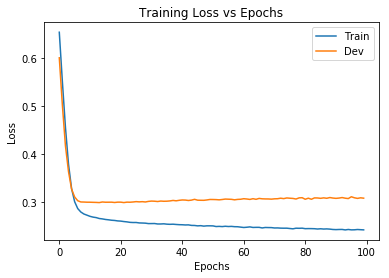

In [58]:
#Determine whether to load the model

load_model = True
saved_losses = {"train":[],
                "dev":[]}

if load_model:
    state = torch.load(os.path.join(os.getcwd(), "model",net.getName()+".pt"))
    net.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    saved_losses["train"] = state["train_loss"]
    saved_losses["dev"]   = state["dev_loss"]
    
    plt.title("Training Loss vs Epochs")
    plt.plot(saved_losses["train"], label="Train")
    plt.plot(saved_losses["dev"], label="Dev")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    


# NOTE: I am using the Test Set for the Dev Set here

In [57]:
max_epochs = 100

epochs_to_print = 25

if use_cuda:
    net.cuda()
    
    
data_loaders = {"train":trainloader, 
                "dev":testloader}
data_lengths = {"train":len(trainloader), 
                "dev":  len(testloader) }

for epoch in range(max_epochs):
    
    for phase in ["train", "dev"]:
        
        running_loss = 0.0
        
        if phase == "train":
#             optimizer = scheduler(optimizer, epoch)
            net.train(True)
        else:
            net.train(False)
            
            
        for i, (minibatch, index) in enumerate(data_loaders[phase]):
            #get the inputs
            one_hot, labels = minibatch["one_hot"], minibatch["labels"]
            if use_cuda:
                one_hot = one_hot.float().cuda()
                labels = labels.float().cuda()
            else:
                one_hot = one_hot.float()
                labels = labels.float()


            #zero the parameter gradients
            optimizer.zero_grad()

            #forward + backward + optimize
            outputs = net(one_hot) #net.forward()
            loss = loss_fn(outputs, labels)
            
            if phase == "train":
                loss.backward()
                optimizer.step()

            #print statistics
            running_loss += loss.item()

        running_loss /= data_lengths[phase]
        saved_losses[phase].append(running_loss)
        print('%5s [%d, %5d] loss: %.3f' %
               (phase, epoch + 1, i + 1, running_loss)) 

### 
# Save the Model
###
saveloc = os.path.join(os.getcwd(), "model")
print("*************************************************************************")
if(not os.path.exists(saveloc)):
    try:
        os.mkdir(saveloc)
    except OSError:
        print("Creation of the directory %s failed" %saveloc)
    else:
        print("Successfully created the directory %s" %saveloc)
print("*************************************************************************")
state = {
    "epoch": epoch,
    "state_dict": net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "train_loss": saved_losses["train"],
    "dev_loss"  : saved_losses["dev"]
}
torch.save(state, os.path.join(saveloc,net.getName()+".pt"))
print("Finished training")

train [1,    42] loss: 0.653
  dev [1,     8] loss: 0.600
train [2,    42] loss: 0.551
  dev [2,     8] loss: 0.502
train [3,    42] loss: 0.456
  dev [3,     8] loss: 0.417
train [4,    42] loss: 0.379
  dev [4,     8] loss: 0.364
train [5,    42] loss: 0.328
  dev [5,     8] loss: 0.327
train [6,    42] loss: 0.301
  dev [6,     8] loss: 0.311
train [7,    42] loss: 0.287
  dev [7,     8] loss: 0.303
train [8,    42] loss: 0.280
  dev [8,     8] loss: 0.301
train [9,    42] loss: 0.276
  dev [9,     8] loss: 0.301
train [10,    42] loss: 0.273
  dev [10,     8] loss: 0.300
train [11,    42] loss: 0.271
  dev [11,     8] loss: 0.300
train [12,    42] loss: 0.269
  dev [12,     8] loss: 0.300
train [13,    42] loss: 0.268
  dev [13,     8] loss: 0.300
train [14,    42] loss: 0.266
  dev [14,     8] loss: 0.299
train [15,    42] loss: 0.266
  dev [15,     8] loss: 0.301
train [16,    42] loss: 0.264
  dev [16,     8] loss: 0.300
train [17,    42] loss: 0.264
  dev [17,     8] loss: 0.30

# Test the Network

In [23]:
#Specify the loader
somevar = "test"

if(somevar == "train"):
    loader = trainloader
    theset = trainset
elif(somevar == "test"):
    loader = testloader
    theset = testset
elif(somevar == "dev"):
    loader = devloader
    theset = devset
else:
    raise ValueError("Please specify what to test on!")

/home/tariq/PokemonTypeNN/utility/evaluation.py:160: RuntimeWarning: invalid value encountered in true_divide
  recall    = (true_pos) / ( (true_pos) + (false_neg))
/home/tariq/PokemonTypeNN/utility/evaluation.py:162: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * precision * recall/ (precision + recall)


True Pos  ::  [ 4.  0.  1.  2.  0.  0.  0.  0.  0.  3. 13.  5.  1.  1.  0.  0.  0.  0.]
False Neg ::  [25.  0.  8.  2.  2.  0.  2.  1.  0.  4. 30. 10.  0.  9.  0.  0.  1.  0.]
False Pos ::  [ 9. 12. 16.  6.  5. 13. 13. 14.  9.  6.  2.  9.  8. 12.  2. 10.  3. 17.]
Actual    ::  [13. 12. 17.  8.  5. 13. 13. 14.  9.  9. 15. 14.  9. 13.  2. 10.  3. 17.]
****************************************
Correctly identified class percentage (True Pos)::  [0.30769231 0.         0.05882353 0.25       0.         0.
 0.         0.         0.         0.33333333 0.86666667 0.35714286
 0.11111111 0.07692308 0.         0.         0.         0.        ]
Recall (average) ::  0.15306122448979592
Precision (average) ::  0.15306122448979592
F1 Score (average) ::  0.15306122448979592
Correctly identified Pokemon percentage ::  0.08064516129032258
Perfectly identified Pokemon :: 
/home/tariq/PokemonTypeNN/data/xydex/popplio.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/xydex/brionne.png  ::  ['water']
/home/ta

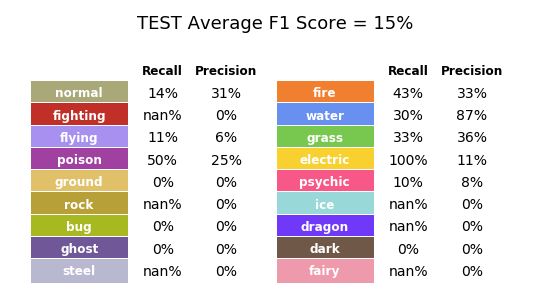

In [48]:
true_pos  = np.zeros(len(classes)) #array of number of times a class was successfully predicted
false_pos = np.zeros(len(classes)) #array of number of times a class was guessed when it should NOT have been guessed
false_neg = np.zeros(len(classes)) #array of number of times a class was not guessed when it should have been guessed
actual_dist = np.zeros(len(classes)) #array of actual number of classes present in the test set

correct_pokemon = [] #list of Pokemon that were perfectly predicted 
pokemon_guesses = {} #dictionary of Pokemon and the NN's type guess
threshold = 0.5

if use_cuda:
    #bring back to CPU so that we can do train/test evaluation
    net.cpu()

with torch.no_grad():
    for i, (minibatch, index) in enumerate(loader):
        one_hot, labels = minibatch["one_hot"], minibatch["labels"]
        one_hot = one_hot.float()
        labels = labels.float()
        outputs = net(one_hot)
        
        for j in range(one_hot.shape[0]):
            
            #see which indices are above our threshold
            poss_indices = outputs[j] >= threshold
            
            #we haven't identified a type! pick the largest type as the prediction
            if(sum(poss_indices) < 1):
                big_class_index = np.argmax(outputs[j].numpy())
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #there are too many types identified! Pick the largest two
            elif(sum(poss_indices) > 2):
                temp_outputs = outputs[j].numpy()
                big_class_index = np.argsort(temp_outputs)[-2:]
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #only 1 or 2 classes beat the threshold! Set only those to 1; everything else to 0
            else:
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][poss_indices] = 1
            
            #create a dictionary of Pokemon and the NN's prediction of its typing
            predicted_type = [classes[c] for c in range(len(classes)) if outputs[j][c] == 1]
            pokemon_guesses[theset.getpokemon(index.numpy()[j])] = predicted_type
            #print(theset.getpokemon(index.numpy()[j]), "\'s type :: ", predicted_type)
            
            
            #Gather NN stats
            numpy_labels  = labels[j].numpy()
            numpy_outputs = outputs[j].numpy()
            
            #number of Pokemon perfectly guessed by NN
            if(np.array_equal(numpy_labels, numpy_outputs)):
                correct_pokemon.append(theset.getpokemon(index.numpy()[j]))
            
            #number of classes present in the test set
            actual_dist[numpy_labels == 1] += 1
            
            #counts the number of correctly identified classes
            #also counts the number of guessed classes by the NN
            for t in range(len(classes)):
                if numpy_labels[t] ==1 and numpy_outputs[t] == 1:
                    true_pos[t] += 1
                    
                if numpy_labels[t] == 1 and numpy_outputs[t] == 0:
                    false_pos[t] += 1
                
                if numpy_labels[t] == 0 and numpy_outputs[t] == 1:
                    false_neg[t] += 1
            
            
       # _, predicted = torch.max(outputs, 1)

         # following code is onlyl for single image identification
#         for j in range(images.shape[0]):
#             print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
#             if(labels.numpy()[j][predicted[j]] == 1):
#                 class_correct[predicted[j]] = class_correct[predicted[j]]+1
#                 correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
    
metrics = getMetrics(true_pos, false_pos, false_neg, actual_dist)

recall = metrics["recall"]
precision = metrics["precision"]
F1 = metrics["F1"]

mean_Recall = metrics["mean_recall"]
mean_Precision = metrics["mean_precision"]
mean_F1 = metrics["mean_F1"]
    
plot_evaluation(somevar.upper(), "Recall", recall, "Precision", precision, "F1", mean_F1)

plt.save()

print("True Pos  :: ", true_pos)
print("False Neg :: ", false_neg)
print("False Pos :: ", false_pos)
print("Actual    :: ", actual_dist)
print("****************************************")
print("Correctly identified class percentage (True Pos):: ", true_pos/actual_dist)
print("Recall (average) :: ", mean_Recall)
print("Precision (average) :: ", mean_Precision)
print("F1 Score (average) :: ", mean_F1)
print("Correctly identified Pokemon percentage :: ", len(correct_pokemon)/theset.__len__())
print("Perfectly identified Pokemon :: ")
for pkm in correct_pokemon:
    print(pkm, " :: ", pokemon_guesses[pkm])
    

#print("Random Guess accuracy :: ", (1/18))


In [20]:
someloc = os.path.join(os.getcwd(), "data", "Train_hot.csv")
somedf = pd.read_csv(someloc)
less = (len(somedf.columns)-(2+18))//4
print(less)
# print(somedf.iloc[0,2:2+18])
print(somedf.iloc[0,2+18:-less])

5
red0       99
blue0     252
green0     90
red1       55
blue1     120
green1     51
red2       97
blue2     204
green2     91
red3       16
blue3      36
green3     15
red4       28
blue4      23
green4     22
Name: 0, dtype: object
